In [2]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.classifyingEdges.classifyingTextNodes import clean_instructional_text, classify_link_pairs_flan_batched
from Stage2.classifyingEdges.classifyingAnEdgeFLANT5 import classify_link_pairs_zero_shot, classify_link_pairs_zero_shot_two_step
#from Stage2.classifyingEdges.classifyingAnEdgeOpenAI import classify_link_pairs_openAI
from Stage2.classifyingEdges.metrics import metrics
#from Stage2.classifyingEdges.classifyingAnEdgeOpenAI import classify_link_pairs_openAI
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
# url = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://westinghousenuclear.com/ → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


In [4]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

/vol/bitbucket/mjh24/IAEA-thesis/Stage2/txtGraphExtraction/extract_mini_txt_graphs_helper.py:141: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


In [5]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, "%'\\s"), normalise_text(b, "%'\\s")])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

In [6]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isInstruction, instructionalTxt = clean_instructional_text(txtsShortened, batch_size=32)
opmask = np.array(isInstruction, dtype=bool)
mask = np.logical_not(opmask)

for key, value in instructionalTxt.items():
    if value == 1:
        print(key)

explore now
learn more about how westinghouse enhances training staffing and outsourcing with options that benefit your plants bottom line
explore our interactive 3d visualization tool for innovative answers to operating plant challenges
access our custom technology library designed for nuclear engineering students and professionals
learn more watch video
join our team
france french
read more
learn more about why databricks selected westinghouse ai for its 2025 data intelligence in energy utility award
explore careers
take a look
blog
explore
learn more
x click on the background to close the video


In [7]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

In [8]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

2256  ->  127


In [ ]:
# Classify the edges
#classificationDeBerta, scoresDeberta = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)
#classificationDeBerta_twostep = classify_link_pairs_zero_shot_two_step(txts, batch_size=64, return_scores=False)
classificationFlan = classify_link_pairs_flan_batched(txts, batch_size=64)
#classificationOpenAI = classify_link_pairs_openAI(txts[:40])
#print(classificationDeBerta)
print(classificationFlan)
#print(classificationDeBerta_twostep)
#print(classificationOpenAI)


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['output_scores']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_scores']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_scores']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The following generation flags are not valid and may be ignored: ['output_scores']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1]
[2, 1, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 2, 2, 3, 2, 2, 1, 1, 3, 3, 1, 3, 3, 3, 3, 3, 1, 3, 2, 2, 1, 2, 2, 3, 1, 3, 2, 1, 1, 1, 3, 3, 1, 3, 2, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 2, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [10]:
y_true_str = "2 2 1 1 ? ? ? ? 3 3 1 1 3 3 2 2 2 2 1 1 ? ? 1 1 3 3 1 1 3 3 1 1 1 1 2 2 2 2 2 2"
#classificationOpenAI = [1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3, 1]
y_true = [3 if tok == "?" else int(tok) for tok in y_true_str.split()]

In [ ]:
#metrics(classificationDeBerta[:len(y_true)], y_true)
metrics(classificationFlan[:len(y_true)], y_true)
#metrics(classificationDeBerta_twostep[:len(y_true)], y_true)
#metrics(classificationOpenAI[:len(y_true)], y_true)

Accuracy: 0.5
Balanced Accuracy: 0.5

Classification report:

              precision    recall  f1-score   support

           1     0.4118    1.0000    0.5833        14
           2     1.0000    0.5000    0.6667        12
           3     0.0000    0.0000    0.0000        14

    accuracy                         0.5000        40
   macro avg     0.4706    0.5000    0.4167        40
weighted avg     0.4441    0.5000    0.4042        40

Accuracy: 0.45
Balanced Accuracy: 0.4444444444444444

Classification report:

              precision    recall  f1-score   support

           1     0.4062    0.9286    0.5652        14
           2     0.5714    0.3333    0.4211        12
           3     1.0000    0.0714    0.1333        14

    accuracy                         0.4500        40
   macro avg     0.6592    0.4444    0.3732        40
weighted avg     0.6636    0.4500    0.3708        40

Accuracy: 0.35
Balanced Accuracy: 0.3333333333333333

Classification report:

              precis

In [12]:
if len(classificationFlan) != len(txts):
    raise Exception("The classification is not the same length as the number of edges")
for (pair, lab) in zip(txts, classificationFlan):
        print(lab, pair)
#for (pair, lab, sc) in zip(txts, classificationDeBerta, scoresDeberta or []):
#        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

2 ['ap300 smr'
 'the ap300 smr is the next evolution of the licensed ap1000 technology']
1 ['the ap300 smr is the next evolution of the licensed ap1000 technology'
 'ap300 smr']
1 ['evinci microreactor'
 'the next generation small modular reactor for remote applications']
1 ['the next generation small modular reactor for remote applications'
 'evinci microreactor']
3 ['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghousenavigator']
2 ['westinghousenavigator'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
1 ['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghouseiq']
1 ['westinghouseiq'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
1 ['when it comes to creating a more sustainable planet the need for renewable energy cant replace the need for safe energy with nuclear power you

['ap300 smr'
 'the ap300 smr is the next evolution of the licensed ap1000 technology']
['the ap300 smr is the next evolution of the licensed ap1000 technology'
 'ap300 smr']
['evinci microreactor'
 'the next generation small modular reactor for remote applications']
['the next generation small modular reactor for remote applications'
 'evinci microreactor']
['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghousenavigator']
['westinghousenavigator'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghouseiq']
['westinghouseiq'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
['when it comes to creating a more sustainable planet the need for renewable energy cant replace the need for safe energy with nuclear power you get the best of b

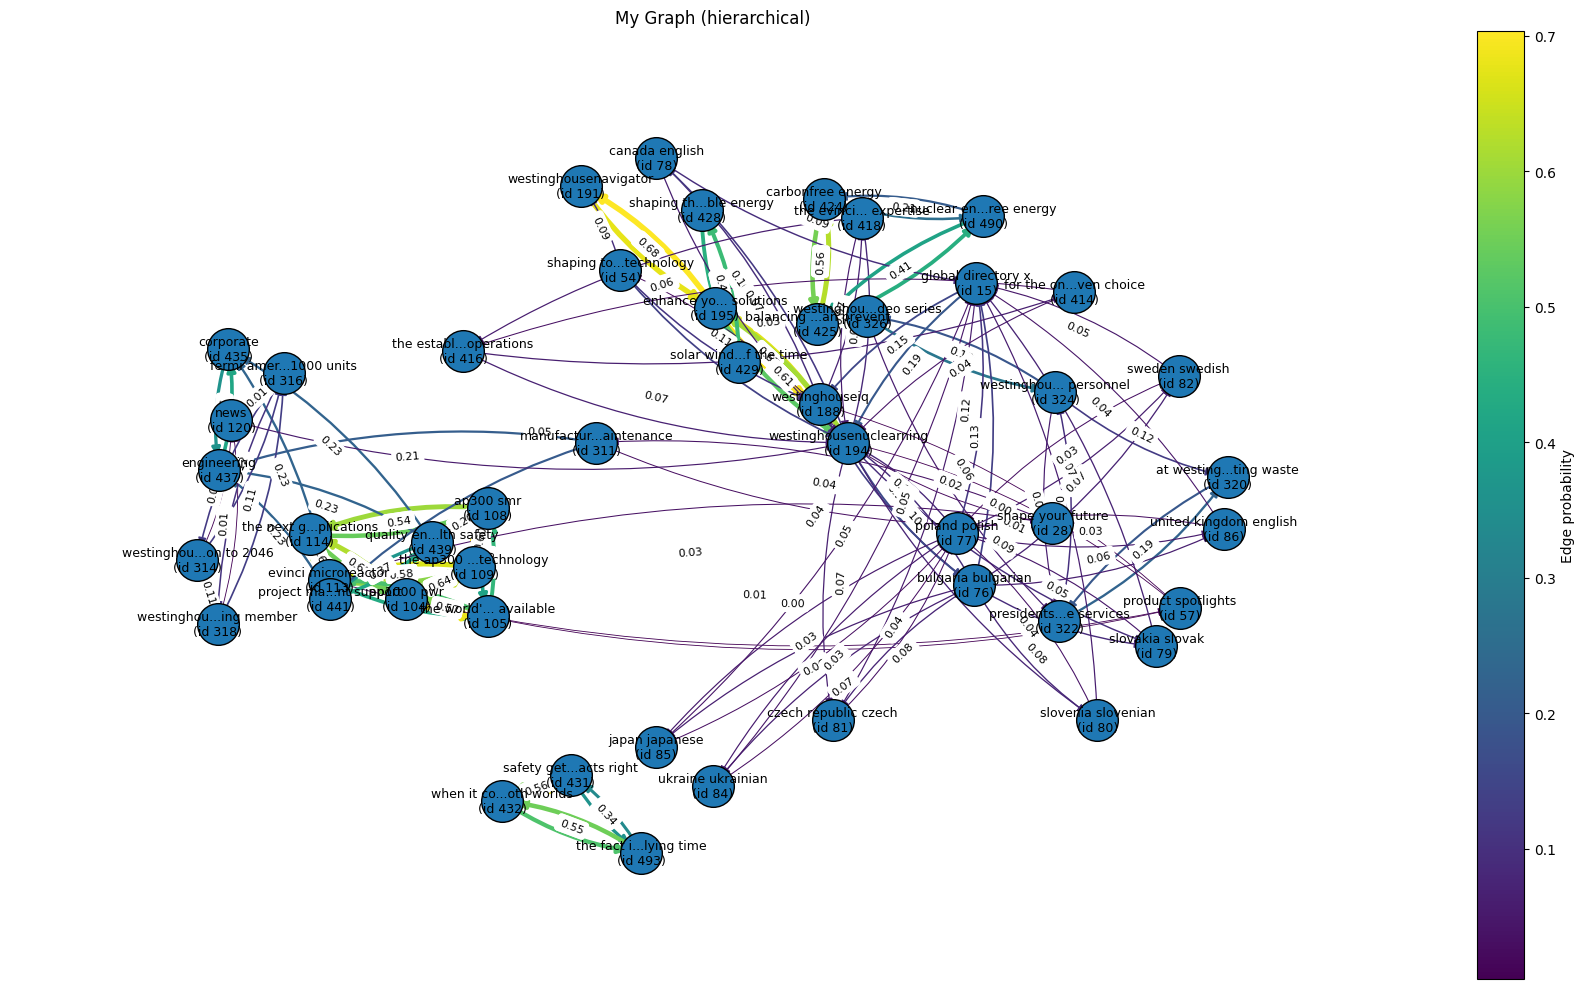

{'G': <networkx.classes.digraph.DiGraph at 0x7cdb61a32120>,
 'pos': {108: array([-0.39637285, -0.0770323 ]),
  109: array([-0.4209749 , -0.23543106]),
  113: array([-0.68555965, -0.27062842]),
  114: array([-0.72029768, -0.14704615]),
  195: array([0.01729892, 0.45999944]),
  191: array([-0.22678083,  0.78727925]),
  188: array([0.20905377, 0.20151939]),
  432: array([-0.37012898, -0.8605967 ]),
  431: array([-0.24493369, -0.79158346]),
  104: array([-0.54503811, -0.31948897]),
  105: array([-0.39633697, -0.36695925]),
  425: array([0.20423955, 0.41652786]),
  424: array([0.21562276, 0.75267435]),
  194: array([0.26036642, 0.0987919 ]),
  493: array([-0.11708213, -1.        ]),
  429: array([0.06149893, 0.31593238]),
  428: array([-0.00680777,  0.72307131]),
  490: array([0.50665579, 0.70644229]),
  441: array([-0.68358452, -0.32029367]),
  439: array([-0.497953 , -0.1680025]),
  437: array([-0.88576378,  0.02577825]),
  435: array([-0.86854298,  0.34968654]),
  326: array([0.29435432,

In [13]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(txts, "%", False) #& mask = keepTopKMask(txts, 1)

numToShow=-1
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=5.0,    # spread layers further
    node_spacing=2.5,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)